# Szeregi czasowe

Zadanie z szeregów czasowych na podstawie wykładu Kamila Książeka

## Importy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data preprocessing

Wczytamy zbiór danych dotyczący zużycia energii w megawatach [MW] zanotowanego przez firmę Commonwealth Edison (ComEd) w Illinois. Zbiór zawiera dane od stycznia 2011 roku do sierpnia 2018 roku.

In [5]:
dataframe = pd.read_csv("/content/COMED_hourly.csv")
dataframe = dataframe.set_index("Datetime")
dataframe.index = pd.to_datetime(dataframe.index)
# Dane w wielu miejscach nie są uporządkowane, co może generować błędy.
# Bardzo ważny punkt analizy szeregów czasowych!
dataframe = dataframe.sort_index()
print(dataframe.head())

                     COMED_MW
Datetime                     
2011-01-01 01:00:00    9631.0
2011-01-01 02:00:00    9273.0
2011-01-01 03:00:00    9011.0
2011-01-01 04:00:00    8741.0
2011-01-01 05:00:00    8694.0


Przyjrzyjmy się teraz danym, dla których będziemy chcieli dokonać predykcji.

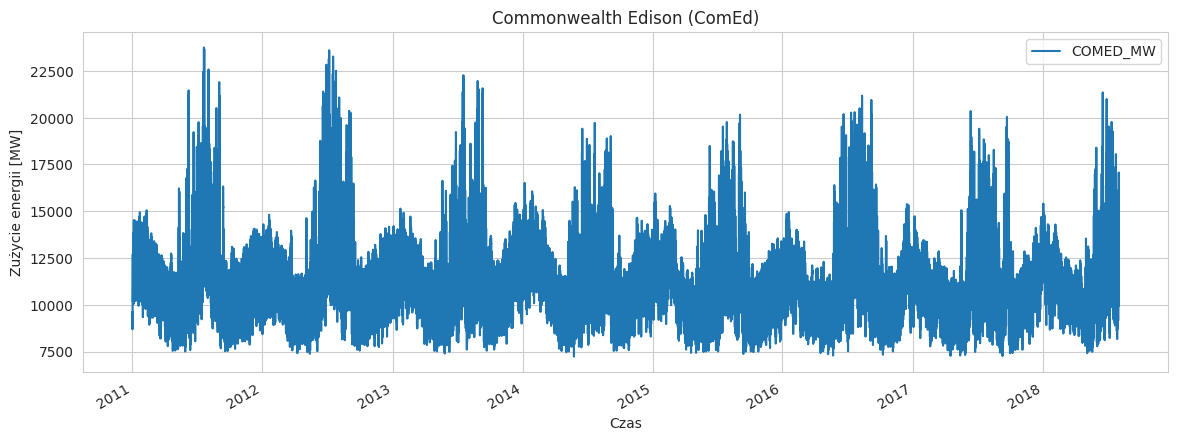

In [6]:
sns.set_style("whitegrid") # style over mathplotlib
#pandas.plot() it is interface between pandas and mathplotlib
dataframe.plot(figsize=(14, 5),
               title="Zużycie energii w MW")
plt.xlabel("Czas")
plt.ylabel("Zużycie energii [MW]")
plt.title("Commonwealth Edison (ComEd)")
plt.show()

Podzielmy dane na zbiór treningowy oraz testowy. Dane do końca 2016 roku będą stanowiły zbiór treningowy, zaś dane od 1 stycznia 2017 roku będą nalezały do zbioru testowego.

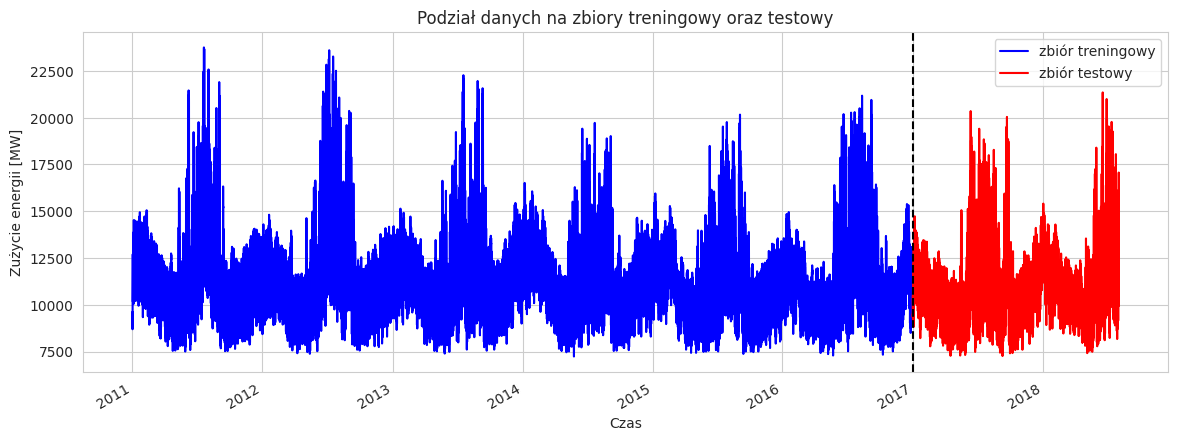

In [7]:
train_set = dataframe.loc[
    dataframe.index < "01-01-2017"
]
test_set = dataframe.loc[
    dataframe.index >= "01-01-2017"
]

fig, ax = plt.subplots(figsize=(14, 5))
train_set.plot(
    ax=ax, label='zbiór treningowy',
    title="Podział danych na zbiory treningowy oraz testowy",
    color='blue'
)
test_set.plot(
    ax=ax, label="zbiór testowy",
    color='red'
)
ax.axvline('01-01-2017', color='black',
           linestyle='dashed')
ax.legend(['zbiór treningowy', 'zbiór testowy'])
plt.xlabel("Czas")
plt.ylabel("Zużycie energii [MW]")
plt.show()

Przyjrzyjmy się teraz bliżej danym z wybranego tygodnia lutego 2012 roku.

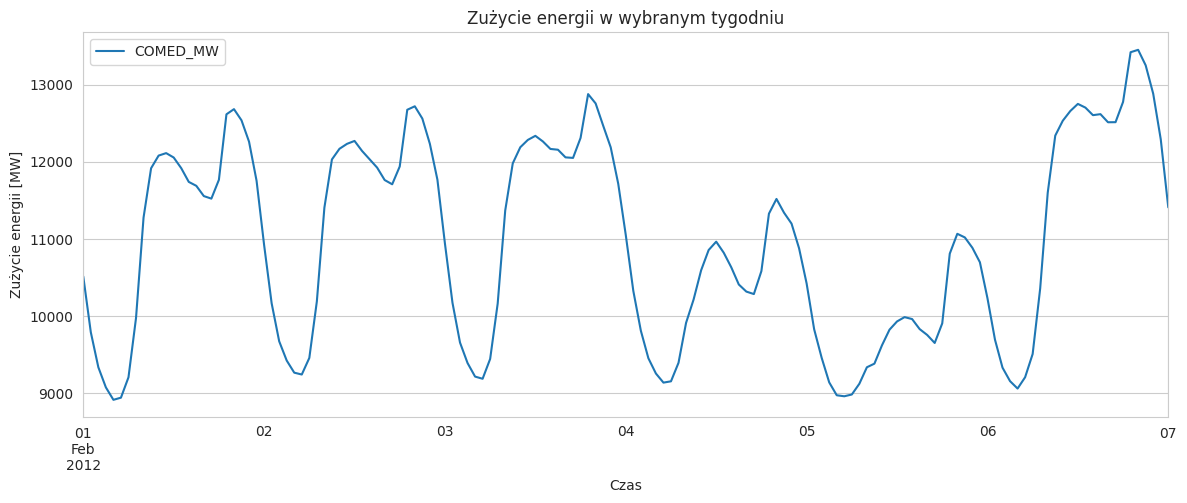

In [8]:
# Prezentacja danych dla wybranego tygodnia pomiarów
fig, ax = plt.subplots(figsize=(14, 5))
selected_week_of_data = dataframe.loc[
    (dataframe.index >= "2012-02-01") &
    (dataframe.index <= "2012-02-07")
]
selected_week_of_data.plot(
    figsize=(14, 5),
    ax=ax,
    title="Zużycie energii w wybranym tygodniu"
)
plt.xlabel("Czas")
plt.ylabel("Zużycie energii [MW]")
plt.show()

Stwórzmy teraz funkcję przygotowującą zbiór danych na wejście do sieci neuronowej. Będą to zarówno dane wejściowe jak i cel do przewidzenia wraz z odpowiadającym znacznikom czasowym.

In [9]:
def prepare_dataset(data, indices, time_horizon, prediction_window):
    """
    Przygotujemy zbiór danych, który będzie zawierał dane o określonym
    horyzoncie czasowym. Do przewidzenia będzie *prediction_window* kolejnych
    wartości i będą one zawarte w zbiorze wartości docelowych.

    Argumenty:
    ----
       *data*: (Numpy array) zawiera kolejne wartości szeregu czasowego
       *indices*: (Pandas DatetimeIndex) zawiera znaczniki czasowe dla kolejnych
                  wartości zawartych w tablicy *data*
       *time_horizon*: (int) określa dostępny horyzont czasowy poprzednich wartości
                       do przewidzenia kolejnych
       *prediction_window*: (int) określa horyzont czasowy do przewidywania
    """
    X, y, target_timestamps = [], [], []
    for i in range(len(data) - time_horizon - prediction_window + 1):
        features = data[i : (i + time_horizon)]
        target = data[(i + time_horizon):(i + time_horizon + prediction_window)]
        timestamps = indices[(i + time_horizon):(i + time_horizon + prediction_window)]
        X.append(features)
        y.append(target)
        target_timestamps.append(timestamps)
    X = torch.tensor(X).to(torch.float32).reshape(-1, time_horizon, 1)
    y = torch.tensor(y).to(torch.float32).reshape(-1, prediction_window)
    return X, y, target_timestamps

Sieć podczas treningu będzie mieć do dyspozycji dane z kolejnych 24 godzin, a będzie miała przewidzieć zużycie energii w kolejnych 6 godzinach.

In [10]:
time_horizon = 24  # 24 kolejne odczyty odpowiadające godzinom
prediction_window = 6
X_train, y_train, train_timestamps = prepare_dataset(
    list(train_set["COMED_MW"].values),
    train_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)
X_test, y_test, test_timestamps = prepare_dataset(
    list(test_set["COMED_MW"].values),
    test_set.index,
    time_horizon=time_horizon,
    prediction_window=prediction_window
)

Teraz należy dokonać przetworzenia wstępnego danych. Należy to uczynić jedynie na danych treningowych, aby uniknąć wycieku danych ze zbioru testowego. Zastosujemy standaryzację. Ustalone parametry zastosujemy zarówno dla danych treningowych jak i testowych.

In [11]:
mean = X_train.mean()
std_deviation = X_train.std()
X_train = (X_train - mean) / std_deviation
X_test = (X_test - mean) / std_deviation
y_train = (y_train - mean) / std_deviation
y_test = (y_test - mean) / std_deviation

## Model

Stworzymy teraz szkielet modelu sieci opartej na komórkach LSTM. Na koniec wstawimy jedną warstwę liniową, która będzie dokonywać predykcji wyników.

In [12]:
class PredictionModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=100, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.LSTM = nn.LSTM(input_size=input_size,  # liczba spodziewanych cech
                            hidden_size=self.hidden_size,  # liczba cech w "hidden state"
                            num_layers=self.num_layers,  # liczba warstw rekurencyjnych
                            batch_first=True)  # wejście będzie miało mieć kształt
                            # (batch, ciąg, cechy)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        # h0 i c0 reprezentują początkowe wartości dla "hidden state" oraz "cell
        # state". Nie są to trenowalne parametry, czyli nie są one aktualizowane
        # podczas wstecznej propagacji.
        # "Hidden state" działa jak rodzaj pamięci, przechowując informacje z
        # poprzednich kroków czasowych. Na początku potrzebuje jednak jakichś
        # wartości początkowych. Po przejściu całej sekwencji zawiera wartościowe
        # informacje dotyczące tej sekwencji.
        # "Cell state" jest innym rodzajem pamięci, ale jest mniej podatny na problem
        # zanikających gradientów niż "hidden state". Podobnie jak h0, potrzebuje
        # pewnych początkowych wartości.
        # Różne sekwencje mogą potrzebować innych punktów początkowych, a inicjalizacja
        # zerami pozwala LSTMowi na dynamiczną adaptację wartości.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        x, _ = self.LSTM(x, (h0, c0))
        # Weźmy ostatnie wyjście z LSTMa, gdyż zawiera ono najbardziej istotne informacje
        # powstałe po przejściu całej sekwencji wejściowej. Normalnie, wyjście LSTMa ma
        # rozmiar (rozmiar batcha, długość sekwencji wejściowej, wielkość stanu ukrytego).
        # Istnieje alternatywne, choć rzadziej stosowane rozwiązanie, żeby do warstwy
        # liniowej wrzucać całe wyjście LSTMa, ale np. po zastosowaniu metody average
        # pooling.
        x = self.linear(x[:, -1, :])
        return x

Jeśli mamy taką możliwość, wytrenujmy model z użyciem GPU.

In [13]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f'Urządzenie: {device}')

Urządzenie: cuda


Przygotujmy funkcję do ustawienia ziarna generatora liczb pseudolosowych, aby zapewnić deterministyczne wyniki treningu sieci.

In [14]:
def set_seed(value):
    """
    Set deterministic results according to the given value
    (including random, numpy and torch libraries)
    """
    np.random.seed(value)
    torch.manual_seed(value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

**UWAGA!!** Poniższy trening jest treningiem poglądowym. Aby uzyskać optymalne wyniki, należałoby dostroić hiperparametry oraz dodać kilka niezbędnych elementów, w szczególności wydzielić zbiór walidacyjny ze zbioru treningowego i na jego podstawie dokonywać wczesnego zatrzymywania treningu (ang. *early stopping*). Poza tym, należałoby ostrożnie wybrać współczynnik uczenia (ang. *learning rate*), rozmiar sekwencji wyjściowej (*output_size*), ilość próbek wchodzących jednocześnie do sieci (*batch_size*) czy wybrać maksymalną liczbę epok treningowych.

Na koniec zapiszemy do pliku wytrenowany model.

In [15]:
def simple_train(model, optimizer, regression_loss, train_dataloader, number_of_epochs = 300, model_name='simple_train_LSTM_model'):
    for epoch in range(number_of_epochs):
        model.train()
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            prediction = model(X_batch)
            loss = regression_loss(prediction, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % 10 != 0:
            continue
        model.eval()
        with torch.no_grad():
            train_prediction = model(X_batch)
            train_RMSE = np.sqrt(regression_loss(train_prediction, y_batch).cpu().detach())
        print(f"Epoka: {epoch}, treningowe RMSE: {train_RMSE}.")
    torch.save(model.state_dict(), model_name)

In [16]:
set_seed(5)
model = PredictionModel(input_size=1, output_size=6).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
regression_loss = nn.MSELoss()
train_dataloader = DataLoader(
    TensorDataset(
        X_train, y_train
    ),
    shuffle=True,
    batch_size=64,
)
number_of_epochs = 100
model_name = 'simple_train_LSTM_model'
simple_train(model, optimizer, regression_loss, train_dataloader, number_of_epochs=number_of_epochs, model_name=model_name)

Epoka: 0, treningowe RMSE: 0.2161932736635208.
Epoka: 10, treningowe RMSE: 0.11790239810943604.
Epoka: 20, treningowe RMSE: 0.09566596150398254.
Epoka: 30, treningowe RMSE: 0.15351393818855286.
Epoka: 40, treningowe RMSE: 0.08509275317192078.
Epoka: 50, treningowe RMSE: 0.09559649974107742.
Epoka: 60, treningowe RMSE: 0.07606509327888489.
Epoka: 70, treningowe RMSE: 0.07560886442661285.
Epoka: 80, treningowe RMSE: 0.06519241631031036.
Epoka: 90, treningowe RMSE: 0.073184072971344.


Wczytajmy teraz nauczony wcześniej model.

In [17]:
model = PredictionModel(input_size=1, output_size=6).to(device)
model.load_state_dict(torch.load(model_name, weights_only=True))
model.eval()


PredictionModel(
  (LSTM): LSTM(1, 100, num_layers=2, batch_first=True)
  (linear): Linear(in_features=100, out_features=6, bias=True)
)

In [18]:
X_test, y_test = X_test.to(device), y_test.to(device)
test_prediction = model(X_test.to(device))
test_RMSE = np.sqrt(regression_loss(test_prediction, y_test).cpu().detach())
print(f"Testowe RMSE: {test_RMSE}.")
transformed_test_prediction = test_prediction * std_deviation + mean
transformed_test_prediction = transformed_test_prediction.cpu().detach()

Testowe RMSE: 0.1781206876039505.


Przygotujmy teraz funkcję dokonującą ostatecznego zestawienia wyników.

In [19]:
def aggregate_predictions(predictions, timestamps_list):
    """
    Agreguje predykcje dla wielu tablic Numpy z różnymi ramkami czasowymi,
    uśredniając je dla takich samych ramek czasowych.

    Argumenty:
    ---------
        *predictions*: (lista zawierająca Numpy array). Każda tablica zawiera
                       M predykcji, każda dla innej ramki czasowej.
        *timestamps_list*: lista obiektów typu pandas.DatetimeIndex lub obiektów typu
                           string lub datetime, reprezentujących ramki czasowe
                           odpowiadające predykcjom w każdej z tablic.

    Wyjście:
    --------
        Pandas DataFrame zawierający zagregowane predykcje, jeden wiersz dla jednej
        ramki czasowej. Zwraca None, jeśli nie będą zachowane rozmiary na wejściu.
    """

    if len(predictions) != len(timestamps_list):
        print("Błąd: liczba tablic z predykcjami oraz zawierających ramki czasowe "
              "muszą być takie same.")
        return None

    # Słownik, który będzie przechowywać zakumulowane predykcje dla ramek czasowych
    timestamp_data = {}

    for i, pred_array in enumerate(predictions):
        timestamps = timestamps_list[i]
        if not isinstance(timestamps, pd.DatetimeIndex):
            timestamps = pd.DatetimeIndex(timestamps)

        for j, prediction in enumerate(pred_array):
            timestamp = timestamps[j]
            if timestamp not in timestamp_data:
                timestamp_data[timestamp] = []
            timestamp_data[timestamp].append(prediction)

    # Stwórzmy obiekt typu Pandas DataFrame i obliczmy średnie dla każdej ramki czasowej.

    df = pd.DataFrame({'timestamp': list(timestamp_data.keys()),
                       'predictions': list(timestamp_data.values())})
    df['prediction_mean'] = df['predictions'].apply(np.mean)
    df = df.drop(columns=['predictions'])
    return df


In [20]:
resulted_dataframe = aggregate_predictions(transformed_test_prediction, test_timestamps)
print(resulted_dataframe)

                timestamp  prediction_mean
0     2017-01-02 00:00:00     10183.855469
1     2017-01-02 01:00:00      9685.586914
2     2017-01-02 02:00:00      9291.458008
3     2017-01-02 03:00:00      9033.814453
4     2017-01-02 04:00:00      8921.500000
...                   ...              ...
13866 2018-08-02 20:00:00     16004.681641
13867 2018-08-02 21:00:00     15370.633789
13868 2018-08-02 22:00:00     14972.424805
13869 2018-08-02 23:00:00     14265.886719
13870 2018-08-03 00:00:00     12954.595703

[13871 rows x 2 columns]


Porównajmy teraz predykcje sieci z rzeczywistymi wartościami.

In [21]:
def visualize_comparison(pred, gt):
    fig, ax = plt.subplots(figsize=(20, 5))
    pred.plot(
        ax=ax, label='predykcje',
        x="timestamp",
        y="prediction_mean",
        title="Porównanie predykcji z rzeczywistymi wartościami szeregu",
        color='blue',
        linewidth=1
    )
    gt.plot(
        ax=ax, label="rzeczywiste wartości",
        color='red',
        linewidth=1,
    )
    ax.legend(['predykcje', 'rzeczywiste wartości'])
    plt.xlabel("Czas")
    plt.ylabel("Zużycie energii [MW]")
    plt.show()

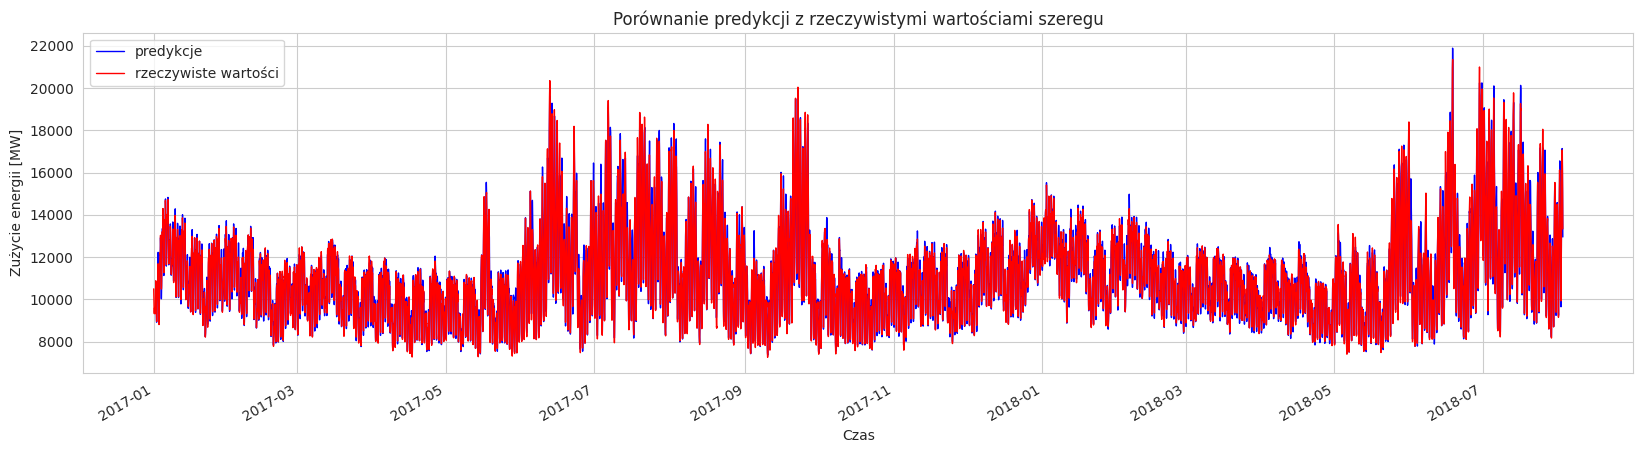

In [22]:
visualize_comparison(resulted_dataframe, test_set)

### Zadanie 1. Data Preparation (1 pkt.)

Podziel dane na train, validation i test sety

In [23]:
# your code here

train_set = dataframe.loc[dataframe.index < "2015-01-01"]
val_set = dataframe.loc[(dataframe.index >= "2015-01-01") & (dataframe.index < "2017-01-01")]
test_set = dataframe.loc[dataframe.index <= "2017-01-01"]

print(train_set.shape[0])
print(val_set.shape[0])
print(test_set.shape[0])

time_horizont = 24
prediction_window = 6

X_train, y_train, train_timestamps = prepare_dataset(
    train_set["COMED_MW"].values,
    train_set.index,
    time_horizont,
    prediction_window)
X_val, y_val, val_timestamps = prepare_dataset(
    val_set["COMED_MW"].values,
    val_set.index,
    time_horizont,
    prediction_window)

X_test, y_test, test_timestamps = prepare_dataset(
    test_set["COMED_MW"].values,
    test_set.index,
    time_horizont,
    prediction_window)
# STANDARTISATION BY TRAIN
mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / std
y_train = (y_train - mean) / std

X_val = (X_val - mean) / std
y_val = (y_val - mean) / std

X_test = (X_test - mean) / std
y_test = (y_test - mean) / std

print(f"Shapes: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"        X_val  ={X_val.shape},   y_val  ={y_val.shape}")
print(f"        X_test ={X_test.shape},  y_test ={y_test.shape}")

35057
17544
52602


<ipython-input-9-1ad84be6c608>:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(X).to(torch.float32).reshape(-1, time_horizon, 1)


Shapes: X_train=torch.Size([35028, 24, 1]), y_train=torch.Size([35028, 6])
        X_val  =torch.Size([17515, 24, 1]),   y_val  =torch.Size([17515, 6])
        X_test =torch.Size([52573, 24, 1]),  y_test =torch.Size([52573, 6])


### Zadanie 2. Train function (1 pkt.)


Napisz funkcję dla trenowania modelu z walidacją

In [24]:
def train(model, optimizer, regression_loss,
          train_dataloader, val_dataloader,
          number_of_epochs=300,
          model_name='my_model'):

    best_val_loss = float('inf')  # будем отслеживать минимальное значение MSE на валидации

    for epoch in range(number_of_epochs):
        # TRAIN
        model.train()
        for X_batch, y_batch in train_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Прямой проход
            prediction = model(X_batch)

            # Функция потерь (MSE)
            loss = regression_loss(prediction, y_batch)

            # Обнуление градиентов и обратный проход
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # VALIDATION
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_dataloader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_pred = model(X_val_batch)

                #  MSE
                val_loss = regression_loss(val_pred, y_val_batch).item()
                val_losses.append(val_loss)

        # Averege MSE
        mean_val_loss = np.mean(val_losses)

        #  MSE -> RMSE
        val_rmse = np.sqrt(mean_val_loss)

        if epoch % 10 == 0:
            print(f"Epoka: {epoch}, val_RMSE: {val_rmse:.4f}")

        # save the best
        if mean_val_loss < best_val_loss:
            best_val_loss = mean_val_loss
            torch.save(model.state_dict(), model_name)

    best_val_rmse = np.sqrt(best_val_loss)
    print(f"Najlepszy wynik walidacji (MSE) = {best_val_loss:.5f}, co odpowiada RMSE = {best_val_rmse:.5f}")


### Zadanie 3. Porównanie modeli rekurencyjnych (6 pkt.)


Porównaj rózne achitektury modeli rekurencyjnych dostępnych w `torch.nn` (`torch.nn.RNN`, `torch.nn.GRU`,`torch.nn.LSTM`) oraz wcześniej poznanych architektur (`Linear`, `MLP`, `CNN`).

Note: Oprócz modułu rekurencyjnego, model ma zawierać także inne warstwy (patrz przykład z `PredictionModel` powyżej)

Wytrenuj każdy z nich funkcją `train` z poprzedniego zadania i wizualizuj wyniki

In [28]:

# DataLoaders (train, val, test)


batch_size = 64
train_dataloader = DataLoader(TensorDataset(X_train, y_train),
                              shuffle=True,  batch_size=batch_size)
val_dataloader   = DataLoader(TensorDataset(X_val,   y_val),
                              shuffle=False, batch_size=batch_size)
test_dataloader  = DataLoader(TensorDataset(X_test,  y_test),
                              shuffle=False, batch_size=batch_size)


# 2. Create all atchitecture


# RNN
class RNNModel(nn.Module):
    def __init__(self, input_size=1, output_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        # x: (batch, seq_len=24, features=1)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.rnn(x, h0)
        # out: (batch, seq_len, hidden_size)
        # берём последний временной шаг
        out = out[:, -1, :]
        out = self.fc(out)        # (batch, 6)
        return out

# GRU
class GRUModel(nn.Module):
    def __init__(self, input_size=1, output_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, hn = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out

# LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, output_size=6, hidden_size=64, num_layers=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(self.hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

#   MLP
# "(24,1) -> vector [24]
class MLPModel(nn.Module):
    def __init__(self, input_size=24, output_size=6, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_size)
        )

    def forward(self, x):
        batch_size = x.size(0)
        # x: (batch, seq_len=24, features=1)
        x = x.view(batch_size, -1)  # -> (batch, 24)
        out = self.net(x)           # -> (batch, 6)
        return out

# ---- (E) CNN ----
class CNNModel(nn.Module):
    def __init__(self, input_size=1, output_size=6, num_filters=16, kernel_size=3):
        super().__init__()
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=num_filters,
            kernel_size=kernel_size
        )
        self.conv2 = nn.Conv1d(
            in_channels=num_filters,
            out_channels=num_filters,
            kernel_size=kernel_size
        )
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)  # сводим seq_len к 1
        self.fc = nn.Linear(num_filters, output_size)

    def forward(self, x):
        # x: (batch, seq_len=24, features=1)
        # Переставим оси: (batch, in_channels=1, seq_len=24)
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)         # (batch, num_filters, 1)
        x = x.squeeze(-1)        # (batch, num_filters)
        out = self.fc(x)         # (batch, 6)
        return out


# 3. TRAIN

regression_loss = nn.MSELoss()
results = {}

def evaluate_on_test(model, test_loader, loss_fn):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for X_b, y_b in test_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            p = model(X_b)
            preds.append(p.cpu())
            targets.append(y_b.cpu())
    preds   = torch.cat(preds)
    targets = torch.cat(targets)
    mse = loss_fn(preds, targets).item()
    return np.sqrt(mse)  # RMSE

# list of objects of architerues
model_list = [
    ("RNN",   RNNModel(input_size=1, output_size=6, hidden_size=64, num_layers=1)),
    ("GRU",   GRUModel(input_size=1, output_size=6, hidden_size=64, num_layers=1)),
    ("LSTM",  LSTMModel(input_size=1, output_size=6, hidden_size=64, num_layers=1)),
    ("MLP",   MLPModel(input_size=24, output_size=6, hidden_dim=64)),
    ("CNN",   CNNModel(input_size=1,  output_size=6, num_filters=16, kernel_size=3))
]

for arch_name, model_instance in model_list:
    print(f"\n--- Trening i walidacja modelu: {arch_name} ---")
    model_instance.to(device)

    optimizer = optim.Adam(model_instance.parameters(), lr=0.001)

    # train zadanie 2
    model_filename = f"best_{arch_name}_model.pt"
    train(
        model=model_instance,
        optimizer=optimizer,
        regression_loss=regression_loss,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        number_of_epochs=50,
        model_name=model_filename
    )

    # count RMSE
    test_rmse = evaluate_on_test(model_instance, test_dataloader, regression_loss)
    results[arch_name] = test_rmse
    print(f"Testowe RMSE dla {arch_name}: {test_rmse:.4f}")

# 4. Comparison

print("\n=== Podsumowanie (RMSE na zbiorze testowym) ===")
for mname, val in results.items():
    print(f"{mname}: RMSE = {val:.4f}")



--- Trening i walidacja modelu: RNN ---
Epoka: 0, val_RMSE: 0.3479
Epoka: 10, val_RMSE: 0.2189
Epoka: 20, val_RMSE: 0.1929
Epoka: 30, val_RMSE: 0.1826
Epoka: 40, val_RMSE: 0.1736
Najlepszy wynik walidacji (MSE) = 0.02722, co odpowiada RMSE = 0.16498
Testowe RMSE dla RNN: 0.1680

--- Trening i walidacja modelu: GRU ---
Epoka: 0, val_RMSE: 0.3367
Epoka: 10, val_RMSE: 0.1869
Epoka: 20, val_RMSE: 0.1701
Epoka: 30, val_RMSE: 0.1592
Epoka: 40, val_RMSE: 0.1653
Najlepszy wynik walidacji (MSE) = 0.02404, co odpowiada RMSE = 0.15504
Testowe RMSE dla GRU: 0.1484

--- Trening i walidacja modelu: LSTM ---
Epoka: 0, val_RMSE: 0.3487
Epoka: 10, val_RMSE: 0.1783
Epoka: 20, val_RMSE: 0.1725
Epoka: 30, val_RMSE: 0.1625
Epoka: 40, val_RMSE: 0.1659
Najlepszy wynik walidacji (MSE) = 0.02496, co odpowiada RMSE = 0.15800
Testowe RMSE dla LSTM: 0.1458

--- Trening i walidacja modelu: MLP ---
Epoka: 0, val_RMSE: 0.2334
Epoka: 10, val_RMSE: 0.1712
Epoka: 20, val_RMSE: 0.1742
Epoka: 30, val_RMSE: 0.1679
Epoka: